In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits
from lmfit import Model, Parameters, minimize
import scipy.ndimage
import copy
from scipy.ndimage.filters import gaussian_filter
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.nddata import Cutout2D
from reproject import reproject_exact

min =  1.183126065556977e+22 , max =  5.406206314648678e+22
Contour levels =  [1.18312607e+22 1.88697277e+22 2.59081948e+22 3.29466619e+22
 3.99851290e+22 4.70235961e+22]


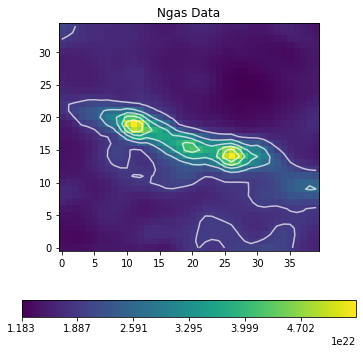

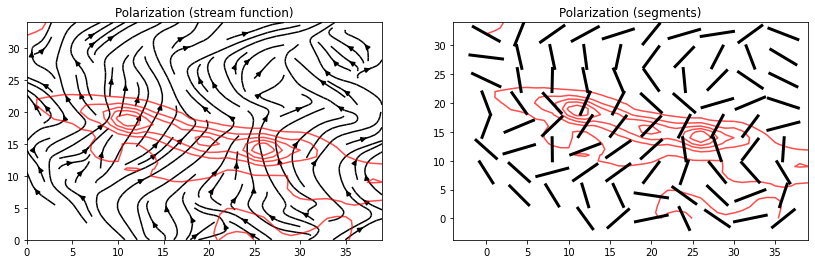

In [12]:
'''
This is where we first make a cut out of the region of interest and look at the polarisation data. Here are a few things to do before we start:
- Make sure that everything is on the same grid, that the polaristion angle is going counter clockwise from north,
    that all the necessary analysis is applied to the PA data beofre starting the process
- Do not forget the velocity dispersion data in km/s and PA data in degrees
- I recommend to do all the work here in its own directory

This process will require some tweaking so make sure that you read every comment so that you can use the scripts to their best potential and 
make your own edits if needed. Good luck!!
'''

#First we set a few constants that we will use. 

#This is the depth of at which we are looking. (2*z in the model) this value is in pixels Make sure that it is large enough but not too big
depth = 60

xcenter=18.628 #location of the x value of the centre of the image (degrees)
ycenter=-0.065 #location of the y value of the centre of the image (degrees)
coords = SkyCoord(l=xcenter*u.degree, b=ycenter*u.degree, frame='galactic', unit= (u.deg) ) #This is for galactic coordinates.
#If using FK5 change it to: SkyCoord(ra=xcenter*u.degree, dec=ycenter*u.degree, frame='FK5', unit= (u.deg) )

width= 40
height= 35 # height of the image (pixels)

num_of_contours = 6 # This is the number of contour levels we want to use when we display the Ngas contours

step = 4 # This determines how many vectors we display if we set it to 1 we display every pixel, 2 we display every 2nd pixel etc...
scale = step # This is the size length of each vector displayed. We recommend to keep it equal to step

distance = 3400 #This is the distance to the object in pc
pc_in_deg = np.degrees(1/distance) #This is the size of one pc at the given distance in degrees
deg_per_pix = 0.003194444 #This is the size of each pixel in degrees (information should be in the header)
pc_in_cm = 3.086e+18 #This is the conversion factor from pc to cm
pix_in_pc = deg_per_pix/pc_in_deg #This calculates how many pc each pixel represents
pix_in_cm = pc_in_cm*deg_per_pix/pc_in_deg #This calculates how many centimeters each pixel represents

#This is where you put the location of the relevant files
column_density_file = '/home/jessym/harvard/fil_5/fits/HIGAL_L_Fil5_Ngas.fits'
BAngle_file = '/home/jessym/harvard/fil_5/fits/Fil5_BAngle_reprojectGal.fits'
widths_file = 'Galregrid_13CO_cube_single_width.fits'

#This marks the end of the needed user inputs for this section-------------------------------------------------------------------------------------

column_fits = fits.open(column_density_file)[0]
column_data = column_fits.data
column_header = column_fits.header
column_world = WCS(column_header)
column_centre = column_world.world_to_pixel(coords) #We find the pixel location of the coordinates given

BAngle_fits = fits.open(BAngle_file)[0]
BAngle_header = BAngle_fits.header
BAngle_data = BAngle_fits.data

widths_fits = fits.open(widths_file)[0]
widths_data = widths_fits.data


widths_reproj = reproject_exact(widths_fits, column_header, return_footprint = False)
widths_cut = Cutout2D(widths_reproj, column_centre, (height, width)).data
B_reproj = reproject_exact((BAngle_data, BAngle_header), column_header, return_footprint = False)
BAngle_data_cut = Cutout2D(B_reproj, column_centre, (height, width)).data


#Making cut outs of the given maps
#widths_cut = Cutout2D(widths_data, column_centre, (height, width)).data
#BAngle_data_cut = Cutout2D(BAngle_data, column_centre, (height, width)).data
data = Cutout2D(column_data, column_centre, (height, width)).data

#Setting up the contours
contour_levels = np.arange(np.nanmin(data), np.nanmax(data), (np.nanmax(data)-np.nanmin(data))/num_of_contours)
print('min = ',np.min(data),', max = ', np.max(data))
print('Contour levels = ', contour_levels)

#Plotting the column density data
Bdir_x = -np.sin(np.radians(np.array(BAngle_data_cut)))
Bdir_y = np.cos(np.radians(np.array(BAngle_data_cut)))
plt.figure(figsize=(6,6))
plt.title('Ngas Data')
plt.imshow(data, origin='lower')
plt.colorbar(location='bottom', ticks = contour_levels)
plt.contour(data, levels=contour_levels, colors = 'white', alpha = 0.7)
#plt.savefig('Ngas_data.pdf')
plt.show()

#Plotting the B-field direction
x = np.arange(0,np.shape(BAngle_data_cut)[1],1)
y = np.arange(0,np.shape(BAngle_data_cut)[0],1)
xarr, yarr = np.meshgrid(x,y)
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.streamplot(xarr,yarr,Bdir_x,Bdir_y, density=1, linewidth=None, color='k')
plt.contour(data, levels=contour_levels, colors = 'r', alpha = 0.7)
plt.title('Polarization (stream function)')
plt.subplot(1,2,2)
plt.contour(data, levels=contour_levels, colors = 'r', alpha = 0.7)
data_angle = np.radians(BAngle_data_cut)
(ys,xs) = data_angle.shape
for y in range(0,ys,step):
    for x in range(0,xs,step):
        r=scale*0.5
        x1_d=x-r*np.sin(data_angle[y,x])   
        y1_d=y+r*np.cos(data_angle[y,x])
        x2_d=x+r*np.sin(data_angle[y,x])
        y2_d=y-r*np.cos(data_angle[y,x])
        plt.plot([x1_d,x2_d],[y1_d,y2_d], color = 'k',  linewidth=3) 

plt.title('Polarization (segments)')
#plt.savefig('Data_polarisation_maps.pdf')
plt.show()

#Normalisong the data for the next steps
med = np.median(data)
norm_data = data/med
norm_contour_levels = contour_levels/med

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
A_1           3.794        1        5   0.3162     True     None     None
A_2           7.728        1       10   0.8471     True     None     None
A_3           3.142        1        5   0.3329     True     None     None
n_0_1         1.588        0      inf      0.3     True     None     None
n_0_2        0.8329        0      inf   0.2098     True     None     None
n_0_3         2.607        0      inf    1.164     True     None     None
n_u         0.01286    1e-06      inf 0.0001289     True     None     None
r_0_1          0.45        0      inf  0.05464     True     None     None
r_0_2        0.4572        0      inf  0.08909     True     None     None
r_0_3        0.3044        0      inf  0.07965     True     None     None
theta_1     -0.4287   -1.571    1.571  0.01863     True     None     None
theta_2     -0.3057   -1.571    1.571   0.0178     True     None     None
theta_3     -0.1589   -1.571    1.5

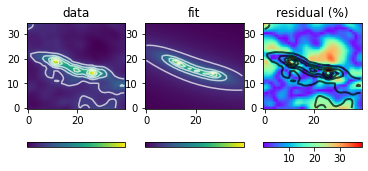

Nu =  1.2600064014414151e+22  [cm^-2]
N01 =  1.5563424265320494e+24  [cm^-2]
N02 =  8.16077579667654e+23  [cm^-2]
N03 =  2.5546428135399596e+24  [cm^-2]
nu =  358.9831099593973  [cm^-3]
n01 =  44341.09571182263  [cm^-3]
n02 =  23250.522154656966  [cm^-3]
n03 =  72783.25102085914  [cm^-3]
r01 =  0.08529852612159362  [pc]
r02 =  0.08667230544749813  [pc]
r03 =  0.05770055243258866  [pc]


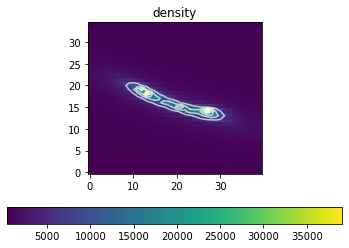

In [13]:
'''
This section is where we find the best fit model to the data.

This model attempts to fit a total of 19 parameters so there is potential for a LOT of degeneracy. We thus need to be careful and make sure that we can
be confident about the results we are getting.
When adding the parameters there are a number of things we can do to reduce the time needed to obtain a fit as well as obtaining a better, 
more accurate fit. Each parameter needs to be set and given an initial value. 
There are a number of limiters we can put on the data the most relevant are:
    - set a maximum and minimum value with max = and min = . This is recomended as it reduces the risk of the model setteling on a non physical solution
    and reduces the time needed to find a best fit.
    - fix the value of the parameter by setting vary = False. It is to true by default.
        - This is useful if you already know the pixel location of the condensations or know that they are spherical etc...
    - set the relation between parameters by setting expr = ''. Let's set the parameters n_0_1 and n_0_2 where we want n_0_2 < n_0_1. This is easily 
    done by adding a new parameter that we'll call 'factor':
    
    params.add('n_0_1', value=np.max(norm_data), min=0)
    params.add(name="factor", value = 0.5, min=0, max=1)
    params.add('n_0_2', value=np.max(norm_data), min=0, expr='n_0_1 * factor')

    This ensures that n_0_2 < n_0_1. 

    To have them be equal we can simply write:
    params.add('n_0_2', value=np.max(norm_data), min=0, expr='n_0_1')
    
    We encourage you to visit this link for more information: https://lmfit.github.io/lmfit-py/parameters.html
'''
#Set a Paramaters instance and add all the necessary parameters, their initial guess and limits
params = Parameters() 
params.add('n_0_1', value=np.max(norm_data), min=0)
#params.add(name="factor", value = 0.5, min=0, max=0.9)
params.add('n_0_2', value=np.max(norm_data), min=0) #, expr='n_0_1 * factor'
params.add('n_0_3', value=np.max(norm_data), min=0)
params.add('r_0_1', value=1.278, min=0.)
params.add('r_0_2', value=1.116, min=0.)
params.add('r_0_3', value=1.141, min=0.)
params.add('n_u', value=np.min(norm_data), min=0.000001)
params.add('A_1', value=1.1, min = 1.0, max = 5, vary = True)
params.add('A_2', value=1.1, min = 1.0, max = 10, vary = True)
params.add('A_3', value=1.1, min = 1.0, max = 5, vary = True)
params.add('theta_1', value=0, min = -np.pi/2, max = np.pi/2, vary = True)
params.add('theta_2', value=0, min = -np.pi/2, max = np.pi/2, vary = True)
params.add('theta_3', value=0, min = -np.pi/2, max = np.pi/2, vary = True)
params.add('xcentre_1', value=12.58  , min = 0, vary = False)
params.add('ycentre_1', value=18.4  , min = 0, vary = False)
params.add('xcentre_2', value=20.53 , min = 0, max = 36, vary = False)
params.add('ycentre_2', value=15.02, min = 0, max = 30, vary = False)
params.add('xcentre_3', value=27.51 , min = 0, vary = False)
params.add('ycentre_3', value= 13.66, min = 0, vary = False)

def fitting(mesh,n_0_1, n_0_2, n_0_3 ,r_0_1, r_0_2, r_0_3, n_u, A_1, A_2, A_3, theta_1, theta_2, theta_3, xcentre_1, ycentre_1, xcentre_2, \
            ycentre_2, xcentre_3, ycentre_3):
    '''
    This is the function that we use to fit the column density. We follow the same methodology as Myers, 2020. 
    
    The function needs the grid over which the model is calculated, the peak number density (n_0), scale length (r_0), aspect ratio (A), 
    incination on the plane of the sky (theta), x and y position for each condensation (xcentre, ycentre) and the background number density
    (or innitial state) number density (n_u). 
    
    We also use the depth through which we are looking though it is not requiered to be given in the function as it is not relevant to the fitting
    
    The function outputs the model in the form of a 2-D numpy array which can be easily displayed using plt.imshow()
    '''
    z = depth/2 #Setting z in the model
    
    #We itterate over every pixel of the mesh and calculate and add together the contribution from each condensation at that location
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            #Changing the x and y coordinates to be wrt the centre of the condensation with the x-axis being along its long axis
            x_1 = (x-xcentre_1)*np.cos(theta_1)+(y-ycentre_1)*np.sin(theta_1) 
            y_1 = -(x-xcentre_1)*np.sin(theta_1)+(y-ycentre_1)*np.cos(theta_1) 
            sqrt_1 = np.sqrt((x_1/A_1)**2+y_1**2+r_0_1**2)
            part_1 = 2*(np.arctan(z/sqrt_1)*n_0_1*r_0_1**2)/sqrt_1 #This is where we calculate the contribution of the condensation at that location
            
            #Now we do the same process for the other two condensations
            x_2 = (x-xcentre_2)*np.cos(theta_2)+(y-ycentre_2)*np.sin(theta_2)
            y_2= -(x-xcentre_2)*np.sin(theta_2)+(y-ycentre_2)*np.cos(theta_2)
            sqrt_2 = np.sqrt((x_2/A_2)**2+y_2**2+r_0_2**2)
            part_2 = 2*(np.arctan(z/sqrt_2)*n_0_2*r_0_2**2)/sqrt_2
            
            x_3 = (x-xcentre_3)*np.cos(theta_3)+(y-ycentre_3)*np.sin(theta_3)
            y_3= -(x-xcentre_3)*np.sin(theta_3)+(y-ycentre_3)*np.cos(theta_3)
            sqrt_3 = np.sqrt((x_3/A_3)**2+y_3**2+r_0_3**2)
            part_3 = 2*(np.arctan(z/sqrt_3)*n_0_3*r_0_3**2)/sqrt_3
            
            mesh[y,x] = part_1+part_2+part_3+2*z*n_u #We add the contributions together and add the effect of the background
            
    return np.array(mesh)

#Making the grid we will use for the model
grid = np.zeros([height, width])

lmfit_model_pro_per = Model(fitting) #Setting the Model instance and defining the model with the function

'''
The command bellow does the fitting. The fitting algorythm uses the standard Levenberg-Marquardt algorithm. There are a number of limitations with that
method so if you wish to use another one you can simply add method = ''. See 
https://lmfit.github.io/lmfit-py/fitting.html#choosing-different-fitting-methods for information on what methods are available.

If you have NaN values in the data you are trying to fit you need to make sure to add nan_policy='omit' or the fitting will give an error
'''
result = lmfit_model_pro_per.fit(norm_data, #the data we are fitting
                               mesh = grid, #the grid we are using for our fit
                               params = params) #the parameters we defined above

#Printing the values of each parameter and their error in a neat way. If you need more information you can uncomment the line bellow
#Note that the number densities and scale lengths printed are in normalised, and pixel units. The true value is printed later in the script.
result.params.pretty_print() 
#print(result.fit_report())

fit =  result.best_fit #Extracting the best fit 

residual = abs((fit - norm_data)/norm_data) #calculating the residuals

#Plotting the results
plt.subplot(1,3,1)
plt.title('data')
plt.imshow(norm_data, origin='lower')
plt.colorbar(ticks = contour_levels, orientation='horizontal') # location = 'bottom')
plt.contour(norm_data, levels=norm_contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.subplot(1,3,2)
plt.title('fit')
plt.imshow(fit, origin='lower')
plt.colorbar(ticks = contour_levels, location = 'bottom')
plt.contour(fit, levels=norm_contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.subplot(1,3,3)
plt.title('residual (%)')
plt.imshow(residual*100, origin='lower', cmap='rainbow')
plt.grid(visible=False)
plt.colorbar(location = 'bottom')
plt.contour(norm_data, levels=norm_contour_levels, colors = 'black', alpha = 0.7, linewidths = 2)
#plt.savefig('best_fit_model_Ngas.pdf')
plt.show()

#extracting the parameters 
n01, n02, n03, r01, r02, r03, nu, A1, A2, A3, theta1, theta2, theta3, x1, y1, x2, y2, x3, y3 = result.params['n_0_1'].value,\
    result.params['n_0_2'].value, result.params['n_0_3'].value, result.params['r_0_1'].value, result.params['r_0_2'].value,result.params['r_0_3'].value,\
    result.params['n_u'].value, result.params['A_1'].value, result.params['A_2'].value, result.params['A_3'].value, result.params['theta_1'].value,\
    result.params['theta_2'].value, result.params['theta_3'].value, result.params['xcentre_1'].value, result.params['ycentre_1'].value, \
    result.params['xcentre_2'].value,result.params['ycentre_2'].value, result.params['xcentre_3'].value, result.params['ycentre_3'].value

#Convert the values to propper units
nu = nu*med/pix_in_cm
n01 = n01*med/pix_in_cm
n02 = n02*med/pix_in_cm
n03 = n03*med/pix_in_cm
print('Nu = ', result.params['n_u'].value*med*depth, ' [cm^-2]')
print('N01 = ', result.params['n_0_1'].value*med*depth, ' [cm^-2]')
print('N02 = ', result.params['n_0_2'].value*med*depth, ' [cm^-2]')
print('N03 = ', result.params['n_0_3'].value*med*depth, ' [cm^-2]')
print('nu = ', nu, ' [cm^-3]')
print('n01 = ', n01, ' [cm^-3]')
print('n02 = ', n02, ' [cm^-3]')
print('n03 = ', n03, ' [cm^-3]')
print('r01 = ', r01*pix_in_pc, ' [pc]')
print('r02 = ', r02*pix_in_pc, ' [pc]')
print('r03 = ', r03*pix_in_pc, ' [pc]')

#Then we calculate the number density of the model at z = 0
def rho(mesh):
    '''
    This function simply calculates the number density of the gas at each pixel
    '''
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
            y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
            frac_1 = (x_1/(A1*r01))**2+(y_1/r01)**2+1
            part_1 = n01/frac_1
            x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
            y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
            frac_2 = (x_2/(A2*r02))**2+(y_2/r02)**2+1
            part_2 = n02/frac_2
            x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
            y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3)
            frac_3 = (x_3/(A3*r03))**2+(y_3/r03)**2+1
            part_3 = n03/frac_3
            mesh[y,x] = part_1+part_2+part_3+nu
            
            
    return np.array(mesh)
#Plotting and saving the figure
density = rho(grid)
density_contour_levels = np.arange(np.nanmin(density), np.nanmax(density), (np.nanmax(density)-np.nanmin(density))/num_of_contours)
plt.title('density')
plt.imshow(density, origin='lower')
plt.colorbar(location='bottom')
plt.contour(density, levels=density_contour_levels, colors = 'white', alpha = 0.7)
#plt.savefig('best_fit_model_Ngas.pdf')
plt.show()

In [29]:
# 1D arrays

#X = width
#Y = height
z = depth/2

mean_molecular_weight = 2.37 
mu_times_mp = mean_molecular_weight*1.68571016E-24
pixel_size_arcsec = 0.003194444*3600
box_height = 15*6.6/3.4
filament_radius_pc = 1.1
distance = 3400 #pc
cm_in_pc = 3085677581279958500 
cm_in_au = 1.49598073e+13
filament_radius_cm = filament_radius_pc*cm_in_pc
R = filament_radius_cm



#grid = np.zeros([Y, X])

#x = np.arange(0,X,1)
#y = np.arange(0,Y,1)
#X,Y = np.meshgrid(x,y)

v01 = n01/nu
v02 = n02/nu
v03 = n03/nu

def lowest_stddev(input_array):
	#delete nan's and unravel
	input_array = np.ravel(input_array)
	nonans = input_array[~np.isnan(input_array)]
	#add 180
	nonans_p180 = [i+180 if i < 0 else i for i in nonans]  
	#nonans_m180 = [i-180 if i > 0 else i for i in nonans]  this is same as above
	#check_distribution(nonans,nonans_p180)
	min_std = np.min([np.std(nonans),np.std(nonans_p180)])
	if np.std(nonans) < np.std(nonans_p180):
		best_median = np.median(nonans)
	else:
		best_median = np.median(nonans_p180)
	return min_std,best_median

def single_1(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
            y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
            frac_1 = (x_1/(A1*r01))**2+(y_1/r01)**2+1
            mesh[y,x] = nu+(n01/frac_1)
    return np.array(mesh)
def single_2(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
            y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
            frac_2 = (x_2/(A2*r02))**2+(y_2/r02)**2+1
            mesh[y,x] = nu+(n02/frac_2)
    return np.array(mesh)
def single_3(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
            y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3)
            frac_3 = (x_3/(A3*r03))**2+(y_3/r03)**2+1
            mesh[y,x] = nu+(n03/frac_3)
    return np.array(mesh)

def sigle_1_Ngas(mesh,n_0_1, r_0_1, n_u, A_1, theta_1, xcentre_1, ycentre_1):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-xcentre_1)*np.cos(theta_1)+(y-ycentre_1)*np.sin(theta_1)
            y_1 = -(x-xcentre_1)*np.sin(theta_1)+(y-ycentre_1)*np.cos(theta_1)
            sqrt_1 = np.sqrt((x_1/A_1)**2+y_1**2+r_0_1**2)
            part_1 = 2*(z*n_u+(np.arctan(z/sqrt_1)*n_0_1*r_0_1**2)/sqrt_1)
            mesh[y,x] = part_1
    return np.array(mesh)

def sigle_2_Ngas(mesh, n_0_2, r_0_2, n_u, A_2, theta_2, xcentre_2, ycentre_2):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_2 = (x-xcentre_2)*np.cos(theta_2)+(y-ycentre_2)*np.sin(theta_2)
            y_2= -(x-xcentre_2)*np.sin(theta_2)+(y-ycentre_2)*np.cos(theta_2)
            sqrt_2 = np.sqrt((x_2/A_2)**2+y_2**2+r_0_2**2)
            part_2 = 2*(z*n_u+(np.arctan(z/sqrt_2)*n_0_2*r_0_2**2)/sqrt_2)
            mesh[y,x] = part_2
    return np.array(mesh)

def sigle_3_Ngas(mesh,n_0_3, r_0_3, n_u, A_3, theta_3, xcentre_3, ycentre_3):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_3 = (x-xcentre_3)*np.cos(theta_3)+(y-ycentre_3)*np.sin(theta_3)
            y_3= -(x-xcentre_3)*np.sin(theta_3)+(y-ycentre_3)*np.cos(theta_3)
            sqrt_3 = np.sqrt((x_3/A_3)**2+y_3**2+r_0_3**2)
            part_3 = 2*(z*n_u+(np.arctan(z/sqrt_3)*n_0_3*r_0_3**2)/sqrt_3)
            mesh[y,x] = part_3
    return np.array(mesh)


first = single_1(grid)
second = single_2(grid)
third = single_3(grid)



first_Ngas = sigle_1_Ngas(grid, n01, r01, nu, A1, theta1, x1, y1)
second_Ngas = sigle_2_Ngas(grid, n02, r02, nu, A2, theta2, x2, y2)
third_Ngas = sigle_3_Ngas(grid, n03, r03, nu, A3, theta3, x3, y3)

# Assign vector directions

n1mean = np.mean(first)
n2mean = np.mean(second)
n3mean = np.mean(third)

t = grid.copy()
s = grid.copy()
ang = grid.copy()
check = grid.copy()
thetaB_1 = grid.copy()
v_bar_1 = grid.copy()
v_1 = grid.copy()
B_x_1 = grid.copy()
B_y_1 = grid.copy()
B_1 = grid.copy()
thetaB_2 = grid.copy()
v_bar_2 = grid.copy()
v_2 = grid.copy()
B_x_2 = grid.copy()
B_y_2 = grid.copy()
thetaB_3 = grid.copy()
v_bar_3 = grid.copy()
v_3 = grid.copy()
B_x_3 = grid.copy()
B_y_3 = grid.copy()
for y in range(len(first)):
    for x in range(len(first[y])):
        x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
        y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
        w1 = np.sqrt((x_1/(A1*r01))**2+(y_1/r01)**2)
        t_1 = (1+v01/(1+w1**2))/(1+(3*v01/(w1**2))*(1-(np.arctan(w1)/w1))) 
        s_1 = x_1/y_1
        thetaB_1[y,x] = np.arctan((1-t_1)/((1/s_1)+(s_1*t_1/(A1**2))))
        v_1[y,x] = (1+v01/(1+w1**2))
        v_bar_1[y,x] = (1+(3*v01/(w1**2))*(1-(np.arctan(w1)/w1))) 
        
        B_x_1[y,x] = np.sin(thetaB_1[y,x]-theta1)*v_1[y,x]*v_bar_1[y,x]**(-1/3)
        B_y_1[y,x] = np.cos(thetaB_1[y,x]-theta1)*v_1[y,x]*v_bar_1[y,x]**(-1/3)

        
        x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
        y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
        w2 = np.sqrt((x_2/(A2*r02))**2+(y_2/r02)**2)
        t_2 = (1+v02/(1+w2**2))/(1+(3*v02/(w2**2))*(1-(np.arctan(w2)/w2))) 
        s_2 = x_2/y_2
        thetaB_2[y,x] = np.arctan((1-t_2)/((1/s_2)+(s_2*t_2/(A2**2))))
        v_2[y,x] = (1+v02/(1+w2**2))
        v_bar_2[y,x] = (1+(3*v02/(w2**2))*(1-(np.arctan(w2)/w2))) 
        B_x_2[y,x] = np.sin(thetaB_2[y,x]-theta2)*v_2[y,x]*v_bar_2[y,x]**(-1/3)  #We set the correction for the elongated core as the fraction between the densities to the 2/3
        B_y_2[y,x] = np.cos(thetaB_2[y,x]-theta2)*v_2[y,x]*v_bar_2[y,x]**(-1/3)
        
        x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
        y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3) 
        w3 = np.sqrt((x_3/(A3*r03))**2+(y_3/r03)**2)
        t_3 = (1+v03/(1+w3**2))/(1+(3*v03/(w3**2))*(1-(np.arctan(w3)/w3))) 
        s_3 = x_3/y_3
        thetaB_3[y,x] = np.arctan((1-t_3)/((1/s_3)+(s_3*t_3/(A3**2))))
        v_3[y,x] = (1+v03/(1+w3**2))
        v_bar_3[y,x] = (1+(3*v03/(w3**2))*(1-(np.arctan(w3)/w3))) 
        B_x_3[y,x] = np.sin(thetaB_3[y,x]-theta3)*v_3[y,x]*v_bar_3[y,x]**(-1/3)
        B_y_3[y,x] = np.cos(thetaB_3[y,x]-theta3)*v_3[y,x]*v_bar_3[y,x]**(-1/3)
        '''
        ang[y,x] = theta
        check[y,x] = (1-t_1)/((1/s_1)+(s_1*t_1/(A1**2)))
        t[y,x] = t_1
        s[y,x] = s_1
        
        if np.sqrt((x1-x)**2+(y1-y)**2) < 15*r01:
            E_x[y,x] = np.sin(-theta1)+(t_1**(2/3))*np.sin(theta-theta1)
            E_y[y,x] = np.cos(-theta1)+(t_1**(2/3))*np.cos(theta-theta1)
        else:
            E_x[y,x] = np.sin(-theta1)
            E_y[y,x] = np.cos(-theta1)
'''
        
        ## data = norm_data
def B_estimate_core(Density_model, Ngas_model, cont_level, Continue, B_x, B_y, v_arr, v_bar_arr, v0, Velocity_dispersion_data,\
                    B_angle_data, Ngas_data,Box_height):
    '''
    Start with cont_level = 0 then choose the appropriate contour and wheter to do density or 
    Run the function with Continue = False first and box_height = 5 then figure out what the box height 
    actually is based on what you see in the cutout plot.
    Once happy with everything just set Continue = True
    '''
    #x = np.arange(0,np.shape(Density_model)[1],1)
    #y = np.arange(0,np.shape(Density_model)[0],1)
    #X,Y = np.meshgrid(x,y)
    
    Density_model_contour_levels = np.arange(np.nanmin(Density_model), np.nanmax(Density_model), (np.nanmax(Density_model)-np.nanmin(Density_model))/10)
    plt.figure(figsize=(10, 5))
    plt.imshow(Density_model, origin='lower')
    plt.colorbar()
    CS = plt.contour(Density_model, levels=Density_model_contour_levels, colors = 'white', alpha = 0.7)
    plt.streamplot(xarr,yarr,B_x,B_y, density=1, linewidth=None, color='white', cmap="autumn")
    plt.title('Magnetic Field')
    plt.show()
    #
    
    
    Ngas_model_contour_levels = np.arange(np.nanmin(Ngas_model), np.nanmax(Ngas_model), (np.nanmax(Ngas_model)-np.nanmin(Ngas_model))/15)
    plt.figure(figsize=(10, 5))
    plt.imshow(Ngas_model, origin='lower')
    CS = plt.contour(Ngas_model, levels=Ngas_model_contour_levels, colors = 'white', alpha = 0.7)
    plt.show()

    emptymap = np.copy(Density_model)
    emptymap[:] = np.nan
    mask = emptymap.copy()

    for i in range(np.shape(Density_model)[0]):
        for j in range(np.shape(Density_model)[1]):
            if Ngas_model_contour_levels[cont_level] <= Ngas_model[i,j]: # and not np.isnan(widths_cut[i,j])
                mask[i,j] = 1
            else:
                mask[i,j] = np.nan

    B_angle_data_crop = B_angle_data*mask
    Velocity_dispersion_data_crop = mask*Velocity_dispersion_data
    v_bar_crop = v_bar_arr*mask
    Ngas_data_crop = Ngas_data*mask

    plt.figure(figsize=(10, 5))
    plt.imshow(Ngas_data_crop, origin='lower')
    CS = plt.contour(Ngas_model, levels=Ngas_model_contour_levels, colors = 'white', alpha = 0.7)
    plt.show()
    if Continue:
        box_height_cm = Box_height*pixel_size_arcsec*distance*cm_in_au
        z = box_height_cm/2


        ave_column = np.nanmean(Ngas_data_crop)
        median_column = np.nanmedian(Ngas_data_crop)
        number_density = ave_column/(np.sqrt(R**2-z**2)+R**2/z*np.arctan(z/np.sqrt(R**2-z**2)))
        sig_PA,median_PA = lowest_stddev(B_angle_data_crop)

        print('Mean Number density: ', number_density)
        print('Median Number density: ', median_column/(np.sqrt(R**2-z**2)+R**2/z*np.arctan(z/np.sqrt(R**2-z**2))))

        B_bar = 0.5*np.sqrt(4*np.pi*number_density*mu_times_mp)*np.nanmean(Velocity_dispersion_data_crop)*100000/np.radians(sig_PA)
        Bu = B_bar/np.nanmin(v_bar_crop)
        print('B_bar :', B_bar)
        print('Bu = ', Bu)
        print('B0 = ', Bu*(1+v0)**(2/3))
        print(v0)
        print('Angle dispersion = ', sig_PA)
        B = Bu*v_arr*(v_bar_arr)**(-1/3)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(Density_model, origin='lower')
        plt.colorbar()
        CS = plt.contour(Density_model, levels=Density_model_contour_levels, colors = 'white', alpha = 0.7)
        plt.streamplot(X,Y,B_x,B_y, density=1, linewidth=None, color=B, cmap="autumn")
        plt.title('Magnetic Field')
        plt.show()
        fix = 1/np.sqrt(B_x**2+B_y**2)
        return (B_x*B*fix, B_y*B*fix)

    
    else:
        return

(B_x_1, B_y_1) = B_estimate_core(Density_model=first, Ngas_model=first_Ngas, cont_level=3, Continue=True, B_x=B_x_1, B_y=B_y_1,\
                                 v_arr=v_1, v_bar_arr=v_bar_1, v0=v01, Velocity_dispersion_data=widths_cut, B_angle_data=BAngle_data_cut,\
                                 Ngas_data=data,Box_height=7)

(B_x_2, B_y_2) = B_estimate_core(Density_model=second, Ngas_model=second_Ngas, cont_level=3, Continue=True, B_x=B_x_2, B_y=B_y_2,\
                                 v_arr=v_2, v_bar_arr=v_bar_2, v0=v02, Velocity_dispersion_data=widths_cut, B_angle_data=BAngle_data_cut,\
                                 Ngas_data=data,Box_height=2)

(B_x_3, B_y_3) = B_estimate_core(Density_model=third, Ngas_model=third_Ngas, cont_level=3, Continue=True, B_x=B_x_3, B_y=B_y_3,\
                                 v_arr=v_3, v_bar_arr=v_bar_3, v0=v03, Velocity_dispersion_data=widths_cut, B_angle_data=BAngle_data_cut,\
                                 Ngas_data=data,Box_height=7)

### Compare N2H+ and 13CO by themsevles

contour_levels = np.arange(np.nanmin(data), np.nanmax(data), (np.nanmax(data)-np.nanmin(data))/6)

B_x = B_x_1+B_x_2+B_x_3
B_y = B_y_1+B_y_2+B_y_3
amp = np.sqrt(B_y**2+B_x**2)
plt.figure(figsize=(10, 5))
plt.imshow(data, origin='lower')
plt.streamplot(xarr,yarr,B_x,B_y, density=1, linewidth=None, color=amp, cmap = 'autumn')
plt.title('Magnetic Field')
plt.title('data')
CS = plt.contour(data, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.streamplot(xarr,yarr,Bdir_x,Bdir_y, density=1, linewidth=None, color='white')
plt.colorbar()
plt.show()


model_angle = np.arctan(-B_x/B_y)
data_angle = np.radians(BAngle_data_cut)
(ys,xs)=model_angle.shape
dlist=[]
list_m=[] # model vector display info
list_r=[] # data vector display info

step=1
scale=step
plt.figure(figsize=(35, 20))
for y in range(0,ys,step):
    for x in range(0,xs,step):
        r=scale*0.5
        x1_m=x-r*np.sin(model_angle[y,x])   
        y1_m=y+r*np.cos(model_angle[y,x])
        x2_m=x+r*np.sin(model_angle[y,x])
        y2_m=y-r*np.cos(model_angle[y,x])
        
        x1_d=x-r*np.sin(data_angle[y,x])   
        y1_d=y+r*np.cos(data_angle[y,x])
        x2_d=x+r*np.sin(data_angle[y,x])
        y2_d=y-r*np.cos(data_angle[y,x])
        
        plt.plot([x1_m,x2_m],[y1_m,y2_m], color = 'k',  linewidth=3)
        plt.plot([x1_d,x2_d],[y1_d,y2_d], color = 'orange',  linewidth=3) 

        #line=np.array([[x1_d,x2_d],[y1_d,y2_d]])
        #list_y_s.append(line)
#gc.show_lines(list_r_s,linewidth=2,color='red')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(amp, origin='lower')
plt.colorbar()
plt.title('B mag')
plt.show()


plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
#plt.figure(figsize=(6,3.4))
#plt.imshow(BAngle_data_cut, origin='lower')
#plt.colorbar(location = 'bottom')
plt.streamplot(xarr,yarr,B_x,B_y, density=1, linewidth=None, color='k')
plt.contour(data, levels=contour_levels, colors = 'black', alpha = 0.7, linewidths = 2)
plt.title('Model polarization (stream function)')
#plt.show()

plt.subplot(1,2,2)
data_angle = np.radians(BAngle_data_cut)
(ys,xs)=data_angle.shape
step=1
scale=step
#plt.figure(figsize=(6,3.4))
for y in range(0,ys,step):
    for x in range(0,xs,step):
        r=scale*0.5
        x1_m=x-r*np.sin(model_angle[y,x])   
        y1_m=y+r*np.cos(model_angle[y,x])
        x2_m=x+r*np.sin(model_angle[y,x])
        y2_m=y-r*np.cos(model_angle[y,x])

        plt.plot([x1_m,x2_m],[y1_m,y2_m], color = 'k',  linewidth=2) 

        #line=np.array([[x1_d,x2_d],[y1_d,y2_d]])
        #list_y_s.append(line)
#gc.show_lines(list_r_s,linewidth=2,color='red')
plt.title('Model polarization (segments)')
plt.contour(data, levels=contour_levels, colors = 'black', alpha = 0.7, linewidths = 2)
plt.savefig('send_phil/model_polarization.pdf')
plt.show()

5.8498871139273e+17
